In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
# Obtain Dataset
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'

--2021-09-12 01:41:37--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  13.6MB/s    in 21s     

2021-09-12 01:41:58 (11.5 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



# Loading Data Set and Assembling Training, Validation, and Test Sets

In [4]:
# Load training dataset, then split into training, validation, and test sets
import torch
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 128

# Number of batches in Training, Validation, Test Sets
TRAINING_BATCHES = 200
VALIDATION_BATCHES = 50
TEST_BATCHES = 100

# Load training data
train_dir = "./tiny-imagenet-200/train"
train_data = torchvision.datasets.ImageFolder(train_dir, transform=transforms.Compose([transforms.ToTensor()]))
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle = True)


# Loop through data loader and add batches and labels based on constants
training_set = []
validation_set = []
test_set = []
i = 0
for set_data in train_data_loader:
  i += 1
  if i <= TRAINING_BATCHES:
    training_set.append(set_data)
  
  elif i <= TRAINING_BATCHES + VALIDATION_BATCHES:
    validation_set.append(set_data)
  
  elif i <= TRAINING_BATCHES + VALIDATION_BATCHES + TEST_BATCHES:
    test_set.append(set_data)
  
  else:
    break

print(len(training_set))
print(len(validation_set))
print(len(test_set))


200
50
100


In [5]:
# Base Hyperparameters for Experiments
LR = 1e-4
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-6
EPOCHS = 8

# Function returns optimizer for model
def get_optimizer (optimizer_spec, model, learning_rate = LR, weight_d = WEIGHT_DECAY, momentum = MOMENTUM):
  print(learning_rate, weight_d, momentum)
  if optimizer_spec == "Adam":
    return torch.optim.Adam(model.parameters(), lr = LR, weight_decay=WEIGHT_DECAY, betas=(momentum, 0.999))

  if optimizer_spec == "Adagrad":
    return torch.optim.Adagrad(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)
  
  if optimizer_spec == "AMSGrad":
    return torch.optim.Adam(model.parameters(), lr = LR, weight_decay=WEIGHT_DECAY, amsgrad = True, betas=(momentum, 0.999))

  if optimizer_spec == "ADADELTA":
    return torch.optim.Adadelta(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY, betas=(momentum, 0.999))
  
  if optimizer_spec == "AdamW":
    return torch.optim.AdamW(model.parameters(), lr = LR, weight_decay = WEIGHT_DECAY, betas=(momentum, 0.999))

# Training Code



In [6]:
def train_model(optimizer_spec, learning_rate = LR, weight_d = WEIGHT_DECAY, momentum = MOMENTUM):
  # Load ResNet50 from Torchvision and modify output layer for TinyImageSet
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = torchvision.models.resnet50(pretrained=True, progress=True)
  model.fc = torch.nn.Linear(in_features=2048, out_features=200)
  model.to(device)
  
  # Define Loss Function and get optimizer
  train_loss = {}
  validation_acc = {}
  loss_f = torch.nn.CrossEntropyLoss()
  optimizer = get_optimizer(optimizer_spec, model, learning_rate, weight_d, momentum)
  epoch_loss = []
  for epoch in range (EPOCHS):
    print("EPOCH : ", epoch)
    model.train()

    # Iterate through training set, collect loss values and update model
    for im, truth_labels in training_set:
      im = im.to(device)
      truth_labels = truth_labels.to(device)
      predicted_labels = model(im)
      loss = loss_f(predicted_labels, truth_labels)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      epoch_loss.append(loss.item())
    train_set_loss = torch.FloatTensor(epoch_loss).mean().item()
    print("TRAIN_LOSS : ", train_set_loss)
    train_loss[epoch] = train_set_loss

    # Iterate through validation set and compute validation accuracy
    # model.eval()
    # accuracies = []
    # for validation_im, validation_labels in validation_set:
    #   validation_im = validation_im.to(device)
    #   validation_labels = validation_labels.to(device)

    #   predicted_labels = model(validation_im).argmax(1)
    #   accuracy = (predicted_labels == validation_labels).float().mean().item()
    #   accuracies.append(accuracy)
    
    # validation_set_accuracy = torch.FloatTensor(accuracies).mean().item()
    # print("******VALIDATION ACCURACY****** : ", validation_set_accuracy)
    # validation_acc[epoch] = validation_set_accuracy

  # Calculate test set accuracy
  model.eval()
  accuracies = []
  for test_im, test_labels in test_set:
      test_im = test_im.to(device)
      test_labels = test_labels.to(device)

      predicted_labels = model(test_im).argmax(1)
      accuracy = (predicted_labels == test_labels).float().mean().item()
      accuracies.append(accuracy)
    
  test_set_accuracy = torch.FloatTensor(accuracies).mean().item()
  print("******TEST ACCURACY****** : ", test_set_accuracy)
  return train_loss, validation_acc, test_set_accuracy

# Learning Rate Ablation Study where LR in [0.1, 0.01, 0.001, 0.0001, 0.0001]

In [ ]:
# Optimizers with Initial Hyperparemeters
train_loss, validation_acc, test_set_accuracy = train_model("Adam")
train_loss, validation_acc, test_set_accuracy = train_model("Adagrad")
train_loss, validation_acc, test_set_accuracy = train_model("AMSGrad")
train_loss, validation_acc, test_set_accuracy = train_model("ADADELTA")
train_loss, validation_acc, test_set_accuracy = train_model("AdamW")

# Optimizers with learning_rate = 1e-3
train_loss, validation_acc, test_set_accuracy = train_model("Adam", learning_rate = 1e-3)
train_loss, validation_acc, test_set_accuracy = train_model("Adagrad", learning_rate = 1e-3)
train_loss, validation_acc, test_set_accuracy = train_model("AMSGrad", learning_rate = 1e-3)
train_loss, validation_acc, test_set_accuracy = train_model("ADADELTA", learning_rate = 1e-3)
train_loss, validation_acc, test_set_accuracy = train_model("AdamW", learning_rate = 1e-3)

# Optimziers with learning _rate = 1e-2
train_loss, validation_acc, test_set_accuracy = train_model("Adam", learning_rate = 1e-2)
train_loss, validation_acc, test_set_accuracy = train_model("Adagrad", learning_rate = 1e-2)
train_loss, validation_acc, test_set_accuracy = train_model("AMSGrad", learning_rate = 1e-2)
train_loss, validation_acc, test_set_accuracy = train_model("ADADELTA", learning_rate = 1e-2)
train_loss, validation_acc, test_set_accuracy = train_model("AdamW", learning_rate = 1e-2)

# Optimizers with learning_rate = 1e-1
train_loss, validation_acc, test_set_accuracy = train_model("Adam", learning_rate = 1e-1)
train_loss, validation_acc, test_set_accuracy = train_model("AMSGrad", learning_rate = 1e-1)
train_loss, validation_acc, test_set_accuracy = train_model("Adagrad", learning_rate = 1e-1)
train_loss, validation_acc, test_set_accuracy = train_model("ADADELTA", learning_rate = 1e-1)
train_loss, validation_acc, test_set_accuracy = train_model("AdamW", learning_rate = 1e-1)

## Results

### Adam:
* Training Loss (lr = 1e-4): {0: 4.425896644592285, 1: 3.371929407119751, 2: 2.5801074504852295, 3: 2.016770362854004, 4: 1.632663369178772, 5: 1.3659847974777222, 6: 1.1731125116348267, 7: 1.02776300907135}
Test Accuracy: 0.48789

* Training Loss (lr = 1e-3) : {0: 3.5611255168914795, 1: 2.561326503753662, 2: 1.9035351276397705, 3: 1.469517707824707, 4: 1.183945894241333, 5: 0.9888197779655457, 6: 0.8484781384468079, 7: 0.7429624795913696}
Test Accuracy: 0.5368

* Training Loss (lr = 1e-2) : {0: 3.522495746612549, 1: 2.5220797061920166, 2: 1.8728904724121094, 3: 1.4464211463928223, 4: 1.1663997173309326, 5: 0.974536120891571, 6: 0.8364256024360657, 7: 0.7324283123016357}
Test Accuracy: 0.5257

* lr = 1e-1
Test Accuracy: 0.5241

### Adagrad:
* Training Loss (lr = 1e-4) : {0: 5.161651611328125, 1: 4.876823902130127, 2: 4.683233737945557, 3: 4.529447555541992, 4: 4.399109363555908, 5: 4.284618377685547, 6: 4.181718826293945, 7: 4.087760925292969}
Test Accuracy: 0.2168

* Training Loss (lr = 1e-3) : {0: 5.022688388824463, 1: 4.727418422698975, 2: 4.519721984863281, 3: 4.352354526519775, 4: 4.2094926834106445, 5: 4.083588123321533, 6: 3.9703288078308105, 7: 3.867000102996826}
Test Accuracy: 0.3086

* Training Loss(lr = 1e-2) : {0: 5.040037631988525, 1: 4.744166374206543, 2: 4.536520957946777, 3: 4.369535446166992, 4: 4.227038383483887, 5: 4.101515769958496, 6: 3.988706350326538, 7: 3.885897159576416}
Test Accuracy : 0.3145

* lr = 1e-1
Test Accuracy = 0.3147

### AMSGrad:
* Training Loss(lr = 1e-4) : {0: 4.348701477050781, 1: 3.2864551544189453, 2: 2.5038833618164062, 3: 1.9540863037109375, 4: 1.5809767246246338, 5: 1.3225914239883423, 6: 1.135908842086792, 7: 0.9953016042709351}
Test accuracy: 0.5202

* Training Loss(lr = 1e-3) : {0: 3.5990564823150635, 1: 2.581326961517334, 2: 1.919771671295166, 3: 1.4830520153045654, 4: 1.1954089403152466, 5: 0.9986127614974976, 6: 0.8570166230201721, 7: 0.7505475878715515}
Test Accuracy : 0.5534

* Training Loss(lr = 1e-2) : {0: 3.5862488746643066, 1: 2.5801281929016113, 2: 1.9168654680252075, 3: 1.4801580905914307, 4: 1.1934632062911987, 5: 0.9969799518585205, 6: 0.8556011319160461, 7: 0.749309778213501}
Test Accuracy : 0.5507

* lr = 1e-1
Test Accuracy : 0.5479

### Adadelta
* Training Loss (lr = 1e-4) : {0: 5.403592586517334, 1: 5.3982672691345215, 2: 5.39301061630249, 3: 5.387814998626709, 4: 5.3826775550842285, 5: 5.377593994140625, 6: 5.372561454772949, 7: 5.3675761222839355}
Test Accuracy: 0.00815

* Training Loss (lr = 1e-3) = {0: 5.400874614715576, 1: 5.3956756591796875, 2: 5.390538215637207, 3: 5.3854546546936035, 4: 5.380420684814453, 5: 5.3754353523254395, 6: 5.370493412017822, 7: 5.365593910217285}
Test Accuracy: 0.006

* Training Loss (lr = 1e-2) = {0: 5.412931442260742, 1: 5.407599925994873, 2: 5.40233850479126, 3: 5.3971381187438965, 4: 5.391995429992676, 5: 5.38690710067749, 6: 5.3818678855896, 7: 5.376876354217529}
Test Accuracy: 0.005

* lr = 1e-1 Test Accuracy: 0.004

### AdamW
* Training Loss (lr = 1e-4) : {0: 3.5578384399414062, 1: 2.5577232837677, 2: 1.9018774032592773, 3: 1.469048261642456, 4: 1.1839369535446167, 5: 0.9889798760414124, 6: 0.8487582802772522, 7: 0.7432935833930969}
Test Accuracy : 0.5502

* Training Loss (lr = 1e-3) : {0: 3.5286338329315186, 1: 2.538924217224121, 2: 1.888421893119812, 3: 1.4586822986602783, 4: 1.175855278968811, 5: 0.9822381734848022, 6: 0.8431072235107422, 7: 0.7384093403816223}
Test Accuracy : 0.5496

* Training Loss(lr = 1e-2) : {0: 3.5498297214508057, 1: 2.5543622970581055, 2: 1.901167392730713, 3: 1.4689738750457764, 4: 1.1844617128372192, 5: 0.9896549582481384, 6: 0.8492757081985474, 7: 0.7436594367027283}
Test Accuracy : 0.5498

* lr = 1e-1
Test accuracy = 0.5506

# Momentum Ablation Study (lr = 1e-2 and weight_decay = 1e-6)

In [ ]:
# Optimizers with Momentum = 0.50
train_loss, validation_acc, test_set_accuracy = train_model("Adam", learning_rate = 1e-2, momentum=0.50)
train_loss, validation_acc, test_set_accuracy = train_model("AMSGrad", learning_rate = 1e-2, momentum=0.50)
train_loss, validation_acc, test_set_accuracy = train_model("AdamW", learning_rate = 1e-2, momentum=0.50)

# Optimizers with Momentum = 0.50
train_loss, validation_acc, test_set_accuracy = train_model("Adam", learning_rate = 1e-2, momentum=0.99)
train_loss, validation_acc, test_set_accuracy = train_model("AMSGrad", learning_rate = 1e-2, momentum=0.99)
train_loss, validation_acc, test_set_accuracy = train_model("AdamW", learning_rate = 1e-2, momentum=0.99)

# Optimizers with Momentum = 0.50
train_loss, validation_acc, test_set_accuracy = train_model("Adam", learning_rate = 1e-2, momentum=0.0)
train_loss, validation_acc, test_set_accuracy = train_model("AMSGrad", learning_rate = 1e-2, momentum=0.0)
train_loss, validation_acc, test_set_accuracy = train_model("AdamW", learning_rate = 1e-2, momentum=0.0)

# Results (lr = 1e-2 and weight_decay = 1e-6)

Adam:
* Momentum = 0.5 => Test Accuracy = 0.5303
* Momemtum = 0.9 => Test Accuracy = 0.5257
* Momentum = 0.99 => Test Accuracy = 0.5075
* Momentum = 0.0 => Test Accuracy = 0.5483

AMSGrad:
* Momentum = 0.5 => Test Accuracy = 0.5531
* Momentum = 0.9 => Test Accuracy = 0.5507
* Momentum = 0.99 => Test Accuracy = 0.5080
* Momentum = 0.0 => Test Accuracy = 0.5433

AdamW:
* Momentum = 0.5 => Test Accuracy = 0.5470
* Momentum = 0.9 => Test Accuracy = 0.5498
* Momentum = 0.99 => Test Accuracy = 0.5073
* Momentum = 0.0 => Test Accuracy = 0.5476


# Weight Decay Ablation Study - Adam vs AdamW

In [ ]:
# Optimizers with Decreasing Weight Decay
train_loss, validation_acc, test_set_accuracy = train_model("Adam", learning_rate = 1e-2, weight_d = 1e-5)
train_loss, validation_acc, test_set_accuracy = train_model("Adam", learning_rate = 1e-2, weight_d = 1e-4)
train_loss, validation_acc, test_set_accuracy = train_model("Adam", learning_rate = 1e-2, weight_d = 1e-3)

# Optimizers with Decreasing Weight Decay
train_loss, validation_acc, test_set_accuracy = train_model("AdamW", learning_rate = 1e-2, weight_d = 1e-5)
train_loss, validation_acc, test_set_accuracy = train_model("AdamW", learning_rate = 1e-2, weight_d = 1e-4)
train_loss, validation_acc, test_set_accuracy = train_model("AdamW", learning_rate = 1e-2, weight_d = 1e-3)


# Results

Adam:
* Weight Decay = 1e-6 => 0.5257
* Weight Decay = 1e-5 => 0.5391
* Weight Decay = 1e-4 => 0.5445
* Weight Decay = 1e-3 => 0.5441

AdamW:
* Weight Decay = 1e-6 => 0.5498
* Weight Decay = 1e-5 => 0.5395
* Weight Decay = 1e-4 => 0.5451
* Weight Decay = 1e-3 => 0.5454


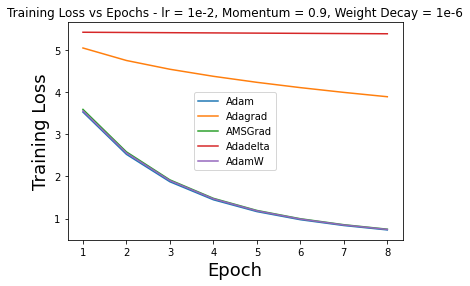

In [30]:
import matplotlib.pyplot as plt
import numpy as np

adam_res = {0: 3.522495746612549, 1: 2.5220797061920166, 2: 1.8728904724121094, 3: 1.4464211463928223, 4: 1.1663997173309326, 5: 0.974536120891571, 6: 0.8364256024360657, 7: 0.7324283123016357}
adagrad_res = {0: 5.040037631988525, 1: 4.744166374206543, 2: 4.536520957946777, 3: 4.369535446166992, 4: 4.227038383483887, 5: 4.101515769958496, 6: 3.988706350326538, 7: 3.885897159576416}
adadelta_res = {0: 5.412931442260742, 1: 5.407599925994873, 2: 5.40233850479126, 3: 5.3971381187438965, 4: 5.391995429992676, 5: 5.38690710067749, 6: 5.3818678855896, 7: 5.376876354217529}
adamw_res = {0: 3.5498297214508057, 1: 2.5543622970581055, 2: 1.901167392730713, 3: 1.4689738750457764, 4: 1.1844617128372192, 5: 0.9896549582481384, 6: 0.8492757081985474, 7: 0.7436594367027283}
amsgrad_res = {0: 3.5862488746643066, 1: 2.5801281929016113, 2: 1.9168654680252075, 3: 1.4801580905914307, 4: 1.1934632062911987, 5: 0.9969799518585205, 6: 0.8556011319160461, 7: 0.749309778213501}

# Loss vs Training Step Plot
adam_x = np.zeros(8)
adagrad_x = np.zeros(8)
amsgrad_x = np.zeros(8)
adadelta_x = np.zeros(8)
adamw_x = np.zeros(8)

adam_y = np.zeros(8)
adagrad_y = np.zeros(8)
amsgrad_y = np.zeros(8)
adadelta_y = np.zeros(8)
adamw_y = np.zeros(8)

for epoch in adam_res:
  adam_x[epoch] = epoch + 1
  adam_y[epoch] = adam_res[epoch]
for epoch in adagrad_res:
  adagrad_x[epoch] = epoch + 1
  adagrad_y[epoch] = adagrad_res[epoch]
for epoch in amsgrad_res:
  amsgrad_x[epoch] = epoch + 1
  amsgrad_y[epoch] = amsgrad_res[epoch]
for epoch in adadelta_res:
  adadelta_x[epoch] = epoch + 1
  adadelta_y[epoch] = adadelta_res[epoch]
for epoch in adamw_res:
  adamw_x[epoch] = epoch + 1
  adamw_y[epoch] = adamw_res[epoch]

plt.plot(adam_x, adam_y, label = "Adam")
plt.plot(adagrad_x, adagrad_y, label = "Adagrad")
plt.plot(amsgrad_x, amsgrad_y, label = "AMSGrad")
plt.plot(adadelta_x, adadelta_y, label = "Adadelta")
plt.plot(adamw_x, adamw_y, label = "AdamW")
plt.title("Training Loss vs Epochs - lr = 1e-2, Momentum = 0.9, Weight Decay = 1e-6")
plt.legend()
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Training Loss', fontsize = 18)
plt.show()

 

In [31]:
!pip install tabulate

In [33]:
from tabulate import tabulate

# Final Accuracies for Optimizers for LR = 1e-2, momentum = 0.9 and weight decay = 1e-6
table = [['Optimizer', 'Test '], ['Adam', 0.5257], ['Adagrad', 0.3145], ['AMSGrad', 0.5507], ['Adadelta', 0.005], ['AdamW', 0.5498]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


╒═════════════╤═════════╕
│ Optimizer   │   Test  │
╞═════════════╪═════════╡
│ Adam        │  0.5257 │
├─────────────┼─────────┤
│ Adagrad     │  0.3145 │
├─────────────┼─────────┤
│ AMSGrad     │  0.5507 │
├─────────────┼─────────┤
│ Adadelta    │  0.005  │
├─────────────┼─────────┤
│ AdamW       │  0.5498 │
╘═════════════╧═════════╛


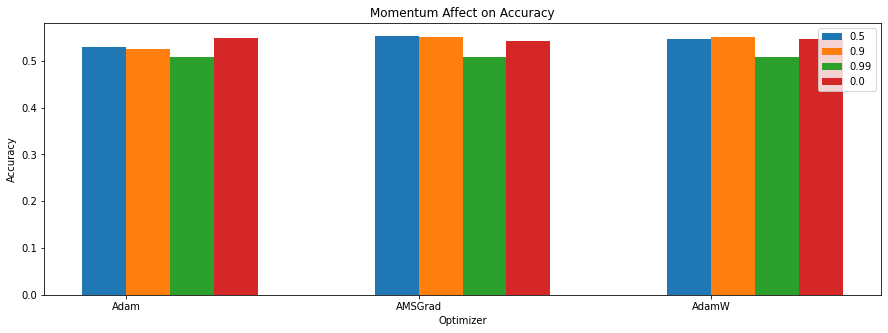

In [ ]:
# Momentum Plot
optimizers = ['Adam', 'AdamW', 'AMSGrad']
accuracies = [[0.5303, 0.5531, 0.5470], 
              [0.5257, 0.5507, 0.5498], 
              [0.5075, 0.5080, 0.5073], 
              [0.5483, 0.5433, 0.5476]]
plt.figure(figsize=(15, 5))
loc = np.arange(3)
width = 0.15
plt.bar(loc, accuracies[0], width, label = "0.5")
plt.bar(loc + width, accuracies[1], width, label = "0.9")
plt.bar(loc + 2 * width, accuracies[2], width, label = "0.99")
plt.bar(loc + 3 * width, accuracies[3], width, label = "0.0")
plt.xticks(loc + width / 2, ('Adam', 'AMSGrad', 'AdamW'))
plt.title("Momentum Affect on Accuracy")
plt.xlabel("Optimizer")
plt.ylabel("Accuracy")
plt.legend(loc = "best")

Text(0, 0.5, 'Accuracy')

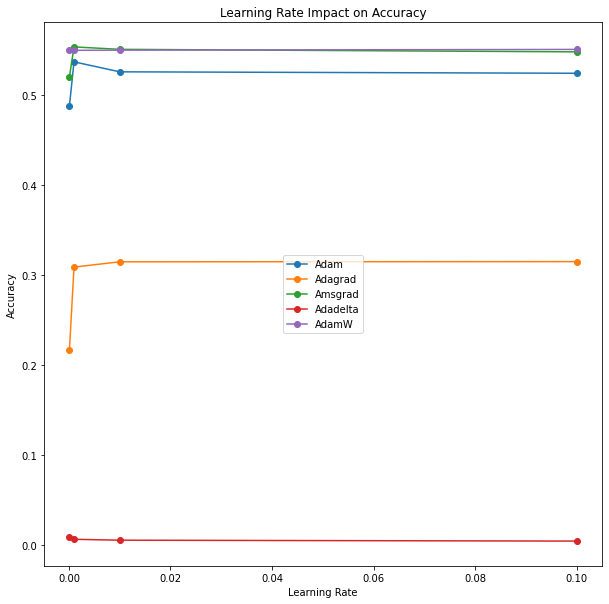

In [72]:
# Learning Rate line plot
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
adam_acc = [0.4879, 0.5368, 0.5257, 0.5241]
adagrad_acc = [0.2168, 0.3086, 0.3145, 0.3147]
amsgrad_acc = [0.5202, 0.5534, 0.5507, 0.5479]
adadelta_acc = [0.008, 0.006, 0.005, 0.004]
adamw_acc = [0.5502, 0.5496, 0.5498, 0.5506]
plt.figure(figsize = (10, 10))
plt.plot(learning_rates, adam_acc, "-o", label = "Adam")
plt.plot(learning_rates, adagrad_acc, "-o", label = "Adagrad")
plt.plot(learning_rates, amsgrad_acc, "-o", label = "Amsgrad")
plt.plot(learning_rates, adadelta_acc, "-o", label = "Adadelta")
plt.plot(learning_rates, adamw_acc, "-o", label = "AdamW")
plt.legend(loc = "center")
plt.title("Learning Rate Impact on Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")

In [81]:
rowIds = ["Adam", "AdamW"]
table = [['1e-6', '1e-5', '1e-4', '1e-3'], [0.5257, 0.5391, 0.5445, 0.5441], [0.5498, 0.5395, 0.5451, 0.5454]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid', showindex=rowIds))

╒═══════╤════════╤════════╤════════╤════════╕
│       │   1e-6 │   1e-5 │   1e-4 │   1e-3 │
╞═══════╪════════╪════════╪════════╪════════╡
│ Adam  │ 0.5257 │ 0.5391 │ 0.5445 │ 0.5441 │
├───────┼────────┼────────┼────────┼────────┤
│ AdamW │ 0.5498 │ 0.5395 │ 0.5451 │ 0.5454 │
╘═══════╧════════╧════════╧════════╧════════╛
